# Example Code for the 1x1 Optimum Filters
-----
Import `qetpy` and other necessary packages.

In [1]:
import numpy as np
import qetpy as qp
from pprint import pprint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pickle

## Use `QETpy` to generate some simulated TES noise

We can use `qetpy.sim.TESnoise` to help create a simulated PSD with characteristic TES parameters.

In [2]:
save_dict_name = 'of_nxm_demo_files/didvresult_muon_example'
with open(save_dict_name, 'rb') as handle:
    didv_dict = pickle.load(handle)

fs = 1.25e6
f = np.fft.fftfreq(32768, d=1/fs)
noisesim = qp.sim.TESnoise(freqs=f, didv_result=didv_dict)

psd_sim = noisesim.s_iload(freqs=f) + noisesim.s_ites(freqs=f) + noisesim.s_itfn(freqs=f)

f_fold, psd_sim_fold = qp.foldpsd(psd_sim, fs=fs)

Automatically determining G
P0 = 50.72686520007603 fW
G = 6.340858150009502e-12 W/K
Calculating dVdI
Calculating dPdI
Done calculating dVdI and dPdI


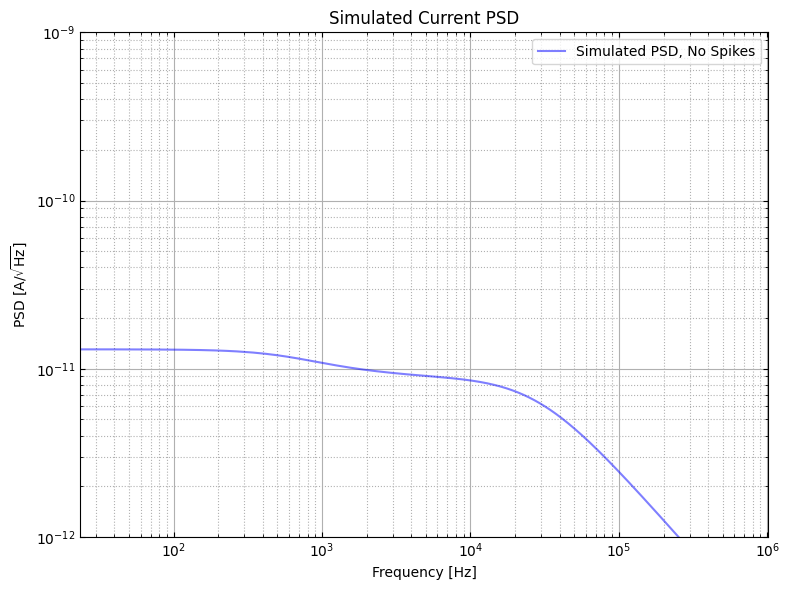

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.loglog(f_fold, psd_sim_fold**0.5, color="blue", alpha=0.5, label="Simulated PSD, No Spikes")
ax.set_ylim((1e-12,1e-9))
ax.grid()
ax.grid(which="minor", linestyle="dotted")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.legend(loc="best")
ax.set_title("Simulated Current PSD")
ax.set_ylabel("PSD [A/$\sqrt{\mathrm{Hz}}$]")
ax.set_xlabel("Frequency [Hz]")
fig.tight_layout()

With a PSD, we can use `qetpy.gen_noise` to generate random noise from the PSD (assuming the frequencies are uncorrelated). Then, we will create an example pulse.

In [4]:
# create a template
pulse_amp = 1.6e-6 # [A]
tau_f = 66e-6 # [s]
tau_r = 20e-6 # [s]

t = np.arange(len(psd_sim))/fs
pretrigger_samples = len(t)//2
pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r)
pulse_shifted = np.roll(pulse, len(t)//2)
template = pulse_shifted/pulse_shifted.max()

# use the PSD to create an example trace to fit
noise = qp.gen_noise_from_psd(psd_sim, fs=fs, ntraces=1)[0]
signal = noise + np.roll(template, 200)*pulse_amp # note the shift we have added, 160 us

## Fit a single pulse with `OptimumFilter`

With a pulse created, let's use the `qetpy.OptimumFilter` class to run different Optimum Filters.

Below, we print the different methods available in `qetpy.OptimumFilter`. In this notebook, we will demo the `ofamp_nodelay`, `ofamp_withdelay`, `ofamp_pileup_iterative`, and `update_signal` methods. It is highly recommend to read the documentation for the other methods, as there are many useful ones!

In [5]:
method_list = sorted([func for func in dir(qp.OF1x1) if callable(getattr(qp.OF1x1, func)) and not func.startswith("__")])
pprint(method_list)

['_calc_chisq0',
 '_calc_chisq_amp',
 '_calc_fit_nodelay',
 '_calc_fit_withdelay',
 '_get_chisq_lowfreq',
 'calc',
 'clear_results',
 'get_amplitude_resolution',
 'get_chisq_nopulse',
 'get_energy_resolution',
 'get_result_nodelay',
 'get_result_withdelay',
 'get_time_resolution',
 'plot']


Let's run the Optimum Filter without and with a time-shifting degree of freedom.

In [6]:
# instantiate OF1x1
OF = qp.OF1x1(template=template, psd=psd_sim, sample_rate=fs,
              pretrigger_samples=pretrigger_samples,
              channel='Sim') # initialize the OptimumFilter class

INFO: Adding template with tag "default" to OF base object.
INFO: Adding noise PSD to OF base object


In [7]:
# calc
OF.calc(signal=signal, window_min_from_trig_usec=-500, window_max_from_trig_usec=500,
        lowchi2_fcutoff=20000,
        interpolate_t0=True, lgc_plot=False)

# get results
amp_nodelay, t0_nodelay, chi2_nodelay, lowchi2_nodelay = OF.get_result_nodelay()
amp_withdelay, t0_withdelay, chi2_withdelay, lowchi2_withdelay = OF.get_result_withdelay()

print(f"\nNo Delay Fit: amp = {amp_nodelay*1e6:.2f} μA, "
      f"χ^2 = {chi2_nodelay:.2f}, low χ^2 = {lowchi2_nodelay:.2f}")
print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, "
      f"t_0 = {t0_withdelay*1e6} μs, χ^2 = {chi2_withdelay:.2f}, "
      f"low χ^2 = {lowchi2_withdelay:.2f}")


No Delay Fit: amp = 0.03 μA, χ^2 = 3598994.46, low χ^2 = 3509861.68
With Delay Fit: amp = 1.60 μA, t_0 = 160.00039321633903 μs, χ^2 = 32575.88, low χ^2 = 975.08


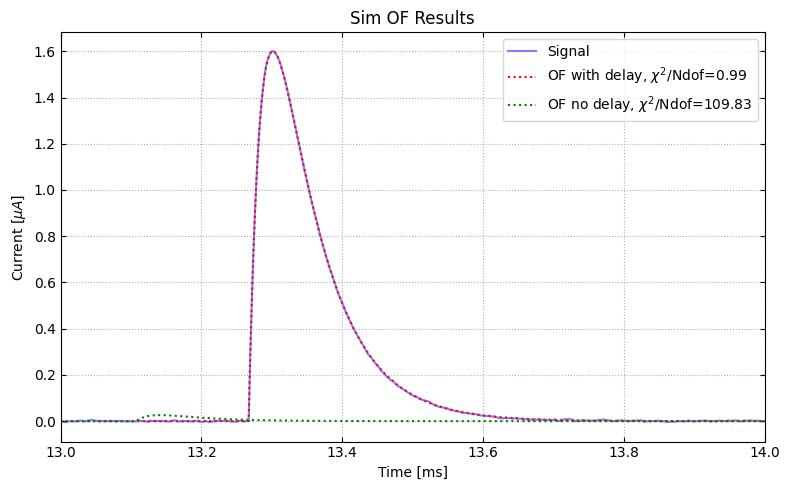

In [8]:
OF.plot(xlim_msec=(13,14))

Since we have added a 160 us shift, we see that the "with delay" optimum filter fit the time-shift perfectly, and the chi-squared is very close to the number of degrees of freedom (32768), as we would expect for a good fit.

### Same example but with OFBase object 

In [9]:
channel = 'Sim'

# instantiate OFBase
OFbase_obj = qp.OFBase(fs)

# add template  (mutiple templates with different tag can be added)
# The function calculate template FFT
OFbase_obj.add_template(channel, template, pretrigger_samples=pretrigger_samples)

# set PSD 
OFbase_obj.set_psd(channel, psd_sim)

# update signal (update each event)
# By default, the function calculate FFT, optimal filter, filtered traces, and chi2/amp all times
# (calculation can be disabled)
OFbase_obj.update_signal(channel, signal)

Let's instantiate OF1x1 and run the Optimum Filter without and with a time-shifting degree of freedom.


No Delay Fit: amp = 0.03 μA, χ^2 = 3598994.46
With Delay Fit: amp = 1.60 μA, t_0 = 160.00039321633903 μs, χ^2 = 32575.88


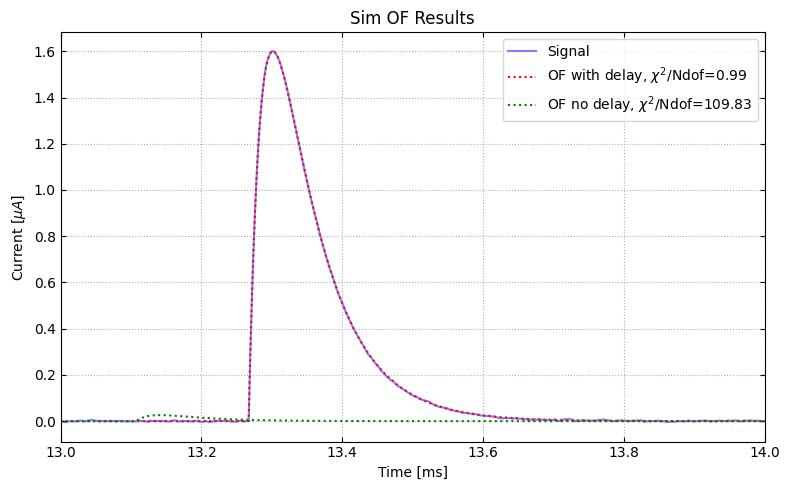

In [10]:
# instantiate
OF = qp.OF1x1(of_base=OFbase_obj, channel=channel)

# calc OF 
OF.calc(window_min_from_trig_usec=-500, window_max_from_trig_usec=500, 
        interpolate_t0=True, lgc_plot=False)

#get results
amp_nodelay, t0_nodelay, chi2_nodelay, chi2low_nodelay = OF.get_result_nodelay()
amp_withdelay, t0_withdelay, chi2_withdelay, chi2low_withdelay = OF.get_result_withdelay()

print(f"\nNo Delay Fit: amp = {amp_nodelay*1e6:.2f} μA, χ^2 = {chi2_nodelay:.2f}")
print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*1e6} μs, χ^2 = {chi2_withdelay:.2f}")

#plot
OF.plot(xlim_msec=(13,14))